In [177]:
import numpy as np
import cv2
import pandas as pd
import os
import importlib
import time
import matplotlib.pyplot as plt
import ntpath

In [178]:
from utils import msop

In [179]:
SRCDIR = 'images/parrington/'
METAPATH = os.path.join(SRCDIR, 'pano.txt')

In [198]:
n_imgs = 3

## Dealing with Meta

In [181]:
with open(METAPATH) as f:
    content = f.readlines()
content = [x.strip() for x in content] 

In [182]:
ii = 0
metas = []
func = None
for line in content:
    if ii == 0:
        if func is None:
            func = ntpath.basename if '\\' in line else os.paht.basename
        meta = {'filename':func(line)}
    elif ii== 11:
        meta['f'] = float(line)
    elif ii == 12:
        ii = 0
        metas.append(meta)
        continue
    ii+=1
    

In [152]:
metas

[{'filename': 'prtn00.jpg', 'f': 704.916},
 {'filename': 'prtn01.jpg', 'f': 706.286},
 {'filename': 'prtn02.jpg', 'f': 705.849},
 {'filename': 'prtn03.jpg', 'f': 706.645},
 {'filename': 'prtn04.jpg', 'f': 706.587},
 {'filename': 'prtn05.jpg', 'f': 705.645},
 {'filename': 'prtn06.jpg', 'f': 705.327},
 {'filename': 'prtn07.jpg', 'f': 704.696},
 {'filename': 'prtn08.jpg', 'f': 703.794},
 {'filename': 'prtn09.jpg', 'f': 704.325},
 {'filename': 'prtn10.jpg', 'f': 704.696},
 {'filename': 'prtn11.jpg', 'f': 703.895},
 {'filename': 'prtn12.jpg', 'f': 704.289},
 {'filename': 'prtn13.jpg', 'f': 704.676},
 {'filename': 'prtn14.jpg', 'f': 704.847},
 {'filename': 'prtn15.jpg', 'f': 704.537},
 {'filename': 'prtn16.jpg', 'f': 705.102},
 {'filename': 'prtn17.jpg', 'f': 705.576}]

## Projection

In [201]:
prjimgs = []
orimgs = []
fs = []
for m in metas[:n_imgs]:
    orimg = cv2.imread(os.path.join(SRCDIR, m['filename']))
    prjimg= msop.cylindrical_projection(orimg, m['f'])
    prjimgs.append(prjimg)
    orimgs.append(orimg)
    fs.append(m['f'])

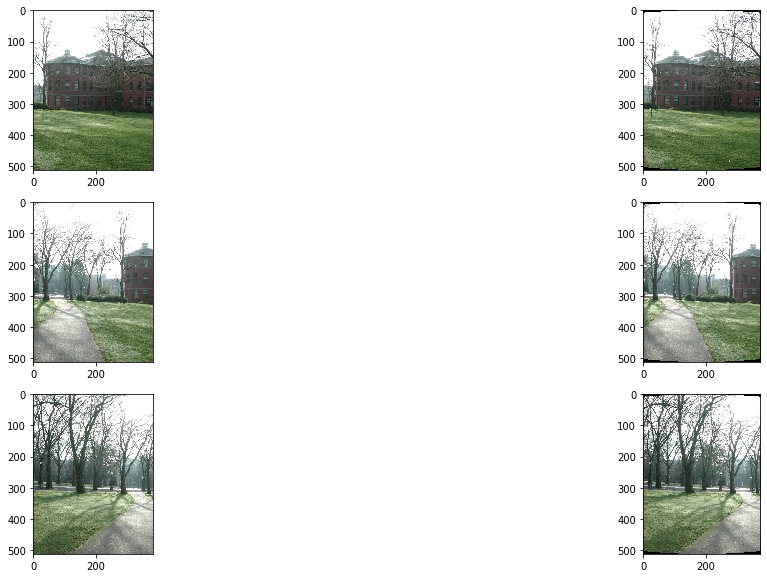

In [202]:
fig=plt.figure(figsize=(20, 10))
columns = 2
rows = len(orimgs)
for i in range(1, rows+1):
    orimg = orimgs[i-1]
    prjimg = prjimgs[i-1]
    fig.subplots_adjust(wspace=0.2)
    fig.add_subplot(rows, columns, i*2-1)
    plt.imshow(cv2.cvtColor(orimg, cv2.COLOR_BGR2RGB)) 
    fig.subplots_adjust(wspace=0.2)
    fig.add_subplot(rows, columns, i*2)
    plt.imshow(cv2.cvtColor(prjimg, cv2.COLOR_BGR2RGB)) 

## Running MSOP

In [238]:
importlib.reload(msop)

<module 'utils.msop' from '/home/tsai/workspace/image-stitching-msop/utils/msop.py'>

In [239]:
descspys = []
for i in range(2):
    descspys.append(msop.msop(orimgs[i], prj=True, focal_length=fs[i])) # put original img into msop function

Computing Harris Corner Response...
Projection to Cylindrical...
Computing Non Maximum Suppression...
Constructing Descriptor...
Computing Harris Corner Response...
Projection to Cylindrical...
Computing Non Maximum Suppression...
Constructing Descriptor...


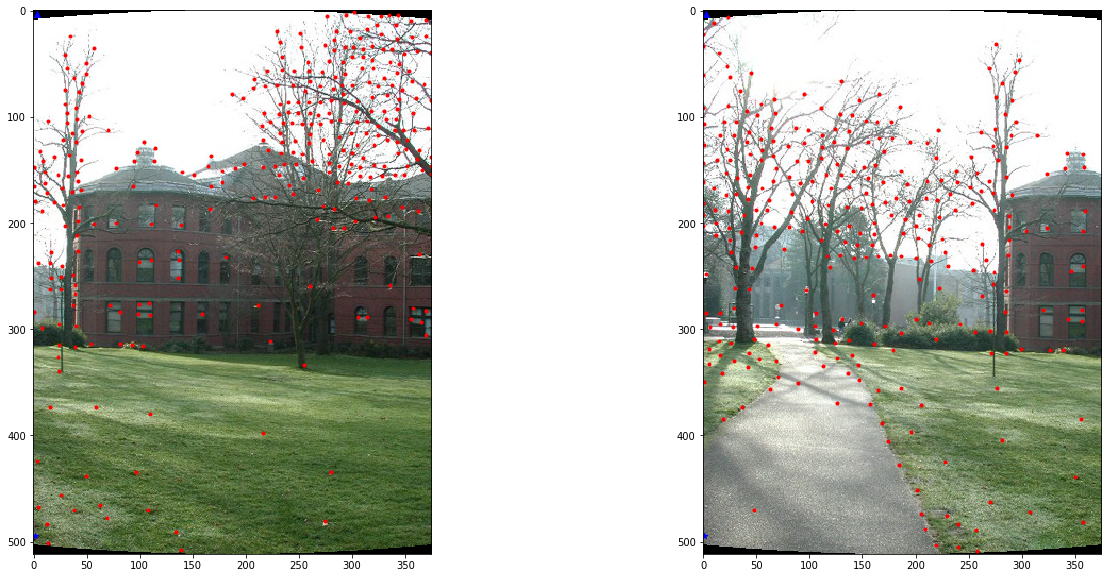

In [336]:
from matplotlib.patches import Rectangle

fig=plt.figure(figsize=(20, 10))
columns = len(descspys)
rows = 1
for i in range(1, columns*rows+1):
    pltimg = prjimgs[i-1]
    
    fig.subplots_adjust(wspace=0.5)
    fig.add_subplot(rows, columns, i)
   
    plt.imshow(cv2.cvtColor(pltimg, cv2.COLOR_BGR2RGB))
    
    #plt.plot( 495, 1, 'g*')
    ax = plt.gca()
    for d in descspys[i-1][0]:
        plt.plot(d.point.y, d.point.x, 'r.')
        #rect = Rectangle( (d.point.y, d.point.x), 30, 30, angle=math.degrees(math.atan2(d.orientation[0], d.orientation[1])), linewidth=1, edgecolor='r', facecolor='none')
        #ax.add_patch(rect)
    plt.plot(1, 495, 'b*')
    plt.plot(3, 3, 'b^')
    
plt.show()

## Feature Matching

In [219]:
def descspy2arr(descspy):
    darrpy = []
    for descs in descspy:
        numd = len(descs)
        dim = descs[0].desc.flatten().shape[0]
        darr = np.zeros((numd, dim))
        for d in range(numd):
            darr[d, :] = descs[d].desc.flatten().astype('float64')
        darrpy.append(darr)
    return darrpy

In [241]:
darrA = descspy2arr(descspys[0])
darrB = descspy2arr(descspys[1])

In [249]:
X = darrA[0]
Y = darrB[0]

In [273]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)


In [274]:
distances, indices = nbrs.kneighbors(Y)

In [306]:
B2Apairs = []

for ind in range(len(distances)):
    ds = distances[ind]
    if (ds[0] < ds[1]*0.7):
        B2Apairs.append((ind, indices[ind][0]))
    

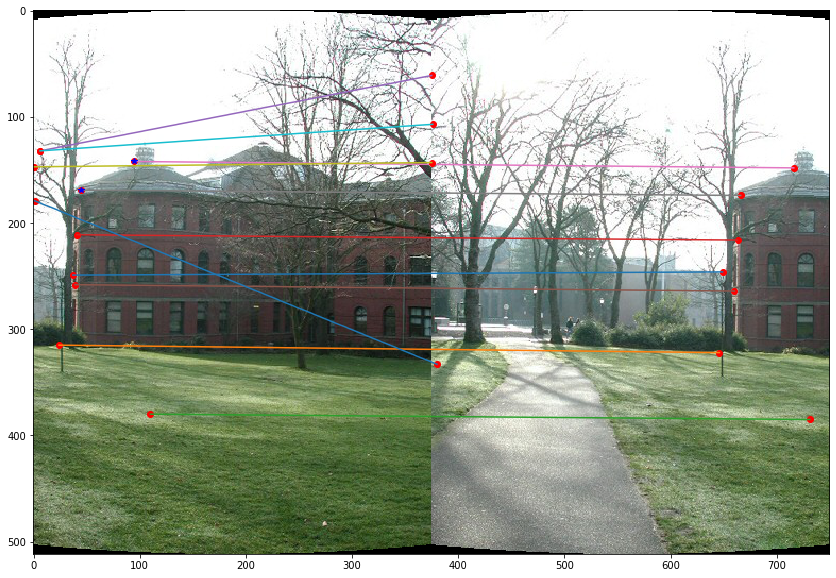

In [409]:
(hA, wA) = prjimgs[0].shape[:2]

(hB, wB) = prjimgs[1].shape[:2]

vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")

vis[0:hA, 0:wA] = prjimgs[0]

vis[0:hB, wA:] = prjimgs[1]
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
#隨機選取顏色，繪製所有放置於matches陣列中，兩點的直線。
for (queryIdx, trainIdx) in B2Apairs:

    color = np.random.randint(0, high=255, size=(3,))
    # train == A == 0
    plt.plot(descspys[0][0][trainIdx].point.y, descspys[0][0][trainIdx].point.x, 'ro')
    ptA = (int(descspys[0][0][trainIdx].point.x), int(descspys[0][0][trainIdx].point.y))
    # query == B == 1
    plt.plot(descspys[1][0][queryIdx].point.y + wA, descspys[1][0][queryIdx].point.x, 'ro')
    ptB = (int(descspys[1][0][queryIdx].point.x), int(descspys[1][0][queryIdx].point.y + wA))

    #plt.plot(y, x)
    plt.plot([ptA[1], ptB[1]], [ptA[0], ptB[0]])
#plt.plot(142, 95, 'b*')
plt.plot(95, 142, 'b*')
plt.plot(45, 169, 'b*')
plt.show()

## Determine Pairwise Alignment

In [338]:
p = 0.5 # probability of real inliers
k = 15 # run RANSAC k times
n = 2 # n samples are all inliers

P = 1 - (1-p**n)**k
print('Probability of success after k trials (P):', P) 

Probability of success after k trials (P): 0.9866365389898419


In [339]:
B2Apairs

[(7, 329),
 (13, 10),
 (30, 47),
 (78, 71),
 (113, 104),
 (138, 107),
 (151, 120),
 (161, 121),
 (163, 239),
 (182, 104),
 (230, 77)]

In [340]:
b2acoords = np.zeros((len(B2Apairs),4))

In [341]:
for i in range(len(B2Apairs)):
    bind, aind = B2Apairs[i]
    # train == A == 0
    # query == B == 1
    # b2acoords [i] = [b.x, b.y, a.x, a.y]
    b2acoords[i] = [descspys[1][0][bind].point.x, descspys[1][0][bind].point.y, descspys[0][0][aind].point.x, descspys[0][0][aind].point.y] 

In [350]:
print(b2acoords)

[[246. 274. 249.  37.]
 [322. 271. 315.  24.]
 [385. 356. 380. 110.]
 [216. 288. 211.  41.]
 [ 61.   0. 132.   6.]
 [264. 285. 258.  39.]
 [148. 341. 142.  95.]
 [174. 291. 169.  45.]
 [143.   0. 147.   0.]
 [107.   1. 132.   6.]
 [333.   5. 179.   1.]]


In [414]:

"""
#Testing
samcoords = np.array([[148, 341, 142,  95], [174, 291, 169,  45]])
m1 = (1/2) * np.sum(samcoords[:, 0] -  samcoords[:, 2])
m2 = (1/2) * np.sum(samcoords[:, 1] -  samcoords[:, 3])
dx = np.abs(m1 - b2acoords[:, 0] +  b2acoords[:, 2]) 
dy = np.abs(m2 - b2acoords[:, 1] +  b2acoords[:, 3])
"""

In [344]:
npairs = len(B2Apairs)

In [425]:
p = 0.5 # probability of real inliers
k = 50 # run RANSAC k times
n = 2 # n samples are all inliers
maxvote = 0
for kdx in range(k):
    samcoords = b2acoords[np.random.choice(npairs, n)]
    # E = sigma((m1 + xi - xi')**2 + (m2 + yi - yi')**2)
    # min(E)
    # m1 = 1/n * sigma(xi - xi')
    # coordB + m1 = coordA
    m1 = (1/n) * np.sum(samcoords[:, 0] -  samcoords[:, 2])
    m2 = (1/n) * np.sum(samcoords[:, 1] -  samcoords[:, 3])
    
    dx = np.abs(m1 +  b2acoords[:, 2] - b2acoords[:, 0]) 
    dy = np.abs(m2 +  b2acoords[:, 3] - b2acoords[:, 1] )
    vote = np.sum(((dx < 10) & (dy < 10)))
    print('vote:%d, (m1, m2): (%d, %d), n:%d'% (vote, m1, m2, n))
    #print(m1, m2)
    if vote > maxvote:
        maxvote = vote
        bestm = (m1, m2)

vote:0, (m1, m2): (-10, 120), n:2
vote:0, (m1, m2): (-10, 121), n:2
vote:5, (m1, m2): (-3, 237), n:2
vote:0, (m1, m2): (-48, -5), n:2
vote:7, (m1, m2): (5, 246), n:2
vote:0, (m1, m2): (41, -1), n:2
vote:0, (m1, m2): (-10, 120), n:2
vote:0, (m1, m2): (-37, -3), n:2
vote:0, (m1, m2): (0, 123), n:2
vote:0, (m1, m2): (-14, -2), n:2
vote:0, (m1, m2): (0, 123), n:2
vote:7, (m1, m2): (6, 246), n:2
vote:0, (m1, m2): (-9, 120), n:2
vote:0, (m1, m2): (-9, 121), n:2
vote:7, (m1, m2): (5, 246), n:2
vote:0, (m1, m2): (-32, 120), n:2
vote:7, (m1, m2): (6, 246), n:2
vote:7, (m1, m2): (6, 246), n:2
vote:0, (m1, m2): (1, 123), n:2
vote:0, (m1, m2): (0, 123), n:2
vote:7, (m1, m2): (5, 246), n:2
vote:0, (m1, m2): (75, 2), n:2
vote:0, (m1, m2): (-33, 120), n:2
vote:6, (m1, m2): (6, 247), n:2
vote:0, (m1, m2): (80, 125), n:2
vote:7, (m1, m2): (1, 242), n:2
vote:7, (m1, m2): (6, 246), n:2
vote:0, (m1, m2): (-14, -2), n:2
vote:7, (m1, m2): (6, 246), n:2
vote:7, (m1, m2): (5, 246), n:2
vote:0, (m1, m2): (-32,

In [426]:
maxvote

7

In [427]:
bestm[0]

5.5

In [428]:
bestm[1]

246.0

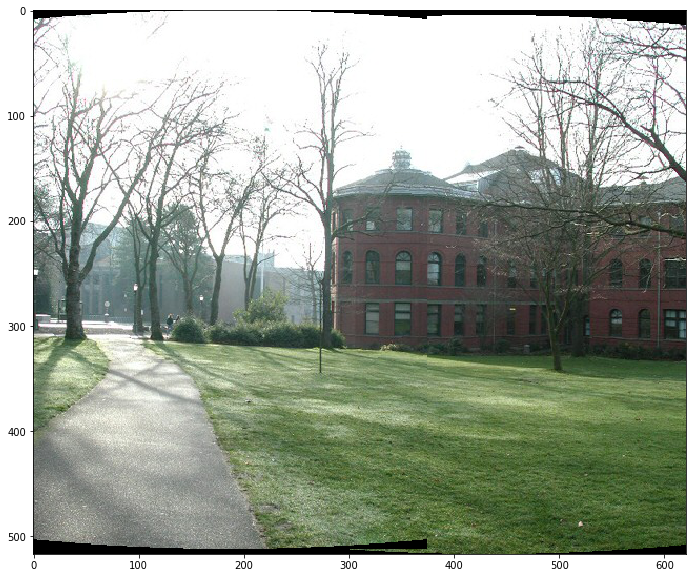

In [430]:
(hA, wA) = prjimgs[0].shape[:2]

(hB, wB) = prjimgs[1].shape[:2]

vis = np.zeros((max(hA, hB) + int(m1), wA + int(m2), 3), dtype="uint8")

vis[int(m1):, int(m2):] = prjimgs[0] # A

vis[0:hB, 0:wB] = prjimgs[1] # B
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
#隨機選取顏色，繪製所有放置於matches陣列中，兩點的直線。
"""
for (queryIdx, trainIdx) in B2Apairs:

    color = np.random.randint(0, high=255, size=(3,))
    # train == A == 0
    plt.plot(descspys[0][0][trainIdx].point.y, descspys[0][0][trainIdx].point.x, 'ro')
    ptA = (int(descspys[0][0][trainIdx].point.x), int(descspys[0][0][trainIdx].point.y))
    # query == B == 1
    plt.plot(descspys[1][0][queryIdx].point.y + wA, descspys[1][0][queryIdx].point.x, 'ro')
    ptB = (int(descspys[1][0][queryIdx].point.x), int(descspys[1][0][queryIdx].point.y + wA))

    #plt.plot(y, x)
    plt.plot([ptA[1], ptB[1]], [ptA[0], ptB[0]])
"""
plt.show()